In [1]:
import sys
sys.path.append('..')
from dataset import DataLoader, DataVisualizer, DatasetBuilder
#from models import *
import tensorflow as tf
from utils.input import *

In [13]:
#create data by copying 3 samples for each class in the demo_data folder
all_dirs = [i for i in os.listdir('../DATA/speech_commands_v0.02')]
# keep only dirs
all_dirs = [i for i in all_dirs if os.path.isdir(os.path.join('../DATA/speech_commands_v0.02', i))]
all_dirs.remove('_background_noise_')
import shutil
for i in all_dirs:
    print (i)
    # copy 3 samples from each class
    if not os.path.exists(os.path.join('demo_data', i)):
        os.makedirs(os.path.join('demo_data', i))
    for j in range(10):
        shutil.copy(os.path.join('../DATA/speech_commands_v0.02', i, os.listdir(os.path.join('../DATA/speech_commands_v0.02', i))[j]), os.path.join('demo_data', i))

right
eight
cat
tree
backward
learn
bed
happy
go
dog
no
wow
follow
nine
left
stop
three
sheila
one
bird
zero
seven
up
visual
marvin
two
house
down
six
yes
on
five
forward
off
four


In [35]:
def input_pipeline(path:str='../DATA/speech_commands_v0.02',
                   method_spectrum:str='log_mel',
                   test_ratio:float=0.15,
                   val_ratio:float=0.05,
                   batch_size:int=64,
                   shuffle_buffer_size:int=1000,
                   shuffle:bool=True,
                   seed:int=42,
                   verbose:int=1):
    """
    Get the data.
    
    Parameters
    ----------
    path : str
        Path to the data.
    method_spectrum : str
        Method to compute the spectrum.
    test_ratio : float
        Ratio of the data to be used as test set.
    val_ratio : float
        Ratio of the data to be used as validation set.
    batch_size : int
        Batch size.
    shuffle_buffer_size : int
        Shuffle buffer size.
    shuffle : bool
        Whether to shuffle the data.
    seed : int
        Seed for the random number generator.
    verbose : int
        Verbosity level.
        
    Returns
    -------
    train : tf.data.Dataset
        Training dataset.
    test : tf.data.Dataset
        Test dataset.
    val : tf.data.Dataset
        Validation dataset.
    commands : list
        List of commands.
    """

    # Get the files.
    data = DataLoader(
        path=path
    )
    
    commands = data.get_commands()
    filenames = data.get_filenames()
    train_files, test_files, val_files = data.split_data(
        filenames=filenames,
        test_ratio=test_ratio,
        val_ratio=val_ratio,
        shuffle=shuffle,
        seed=seed,
        verbose=verbose
    )

    ds = DatasetBuilder(
        commands=commands,
        train_filenames=train_files,
        test_filenames=test_files,
        val_filenames=val_files,
        batch_size=batch_size,
        buffer_size=shuffle_buffer_size,
        method=method_spectrum
    )
    
    train, test, val = ds.preprocess_dataset_spectrogram()
    return train, test, val, commands

In [90]:
# load model
import sys 
sys.path.append('..')
from models import *
from model import *


data = DataLoader(path='demo_data')
commands = data.get_commands()
filenames = data.get_filenames()
train_files, val_files, test_files = data.split_data(filenames)

ds = DatasetBuilder(
    commands=commands,
    train_filenames=train_files,
    val_filenames=val_files,
    test_filenames=test_files,
    batch_size=64,
    buffer_size=1000,
    method='log_mel'
)
waveforms = data.get_waveform_ds(train_files)
ds = data.get_spectrogram_logmel_ds(waveforms, commands)

N = 10
imgs = []
labels = []
for i in ds.take(N):
    img = i[0].numpy()
    label = i[1].numpy()
    imgs.append(img)
    labels.append(label)


train, test, val, commands = input_pipeline(path='demo_data')
model_name = 'DNNBaseline'
model_path= f'../models/{model_name}.h5'
model = globals()[model_name](
                            train_ds=train,
                            test_ds=test,
                            val_ds=val,
                            commands=commands
                        )
model.define_model()
model.load_weights(model_path)
model = model.model

expimgs = map(lambda x: tf.expand_dims(x, axis=0), imgs)
preds = model.predict(expimgs)
pred = [np.argmax(i) for i in preds]

label2idx = {i:idx for idx, i in enumerate(commands)}
idx2label = {idx:i for idx, i in enumerate(commands)}
original_label = [idx2label[i] for i in labels]
predicted_label = [idx2label[i] for i in pred]


10/10 [==============================] - 0s 3ms/step


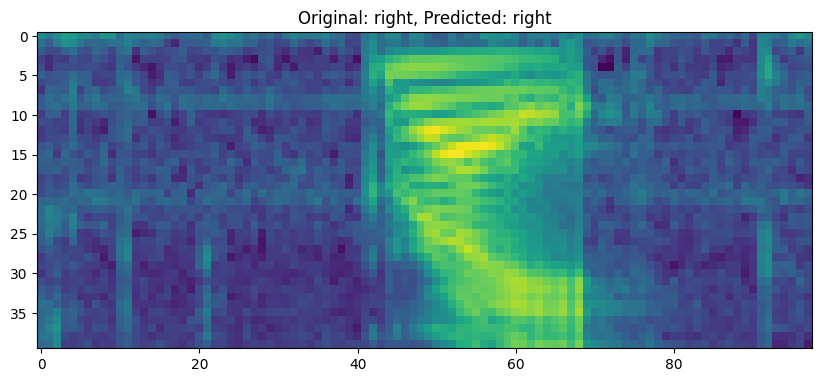

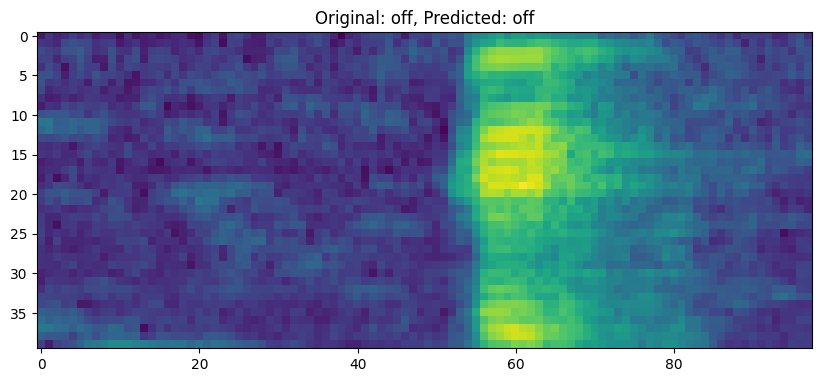

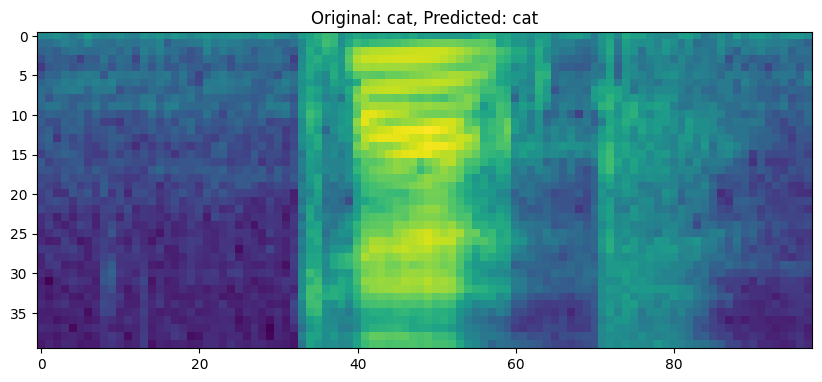

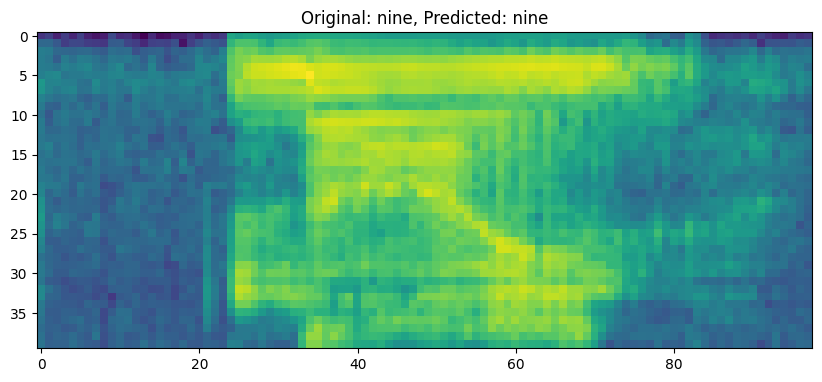

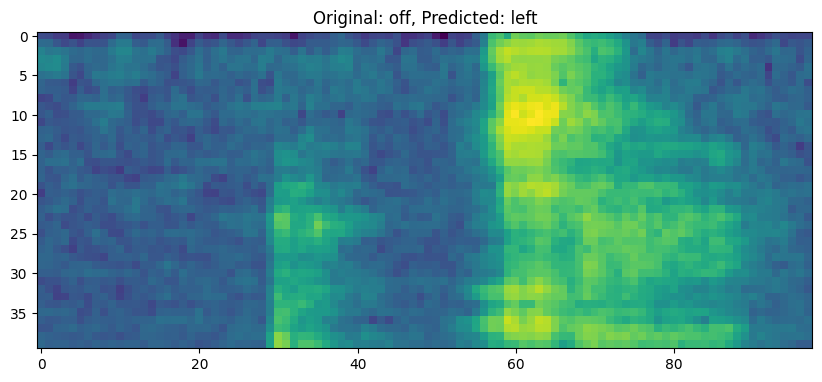

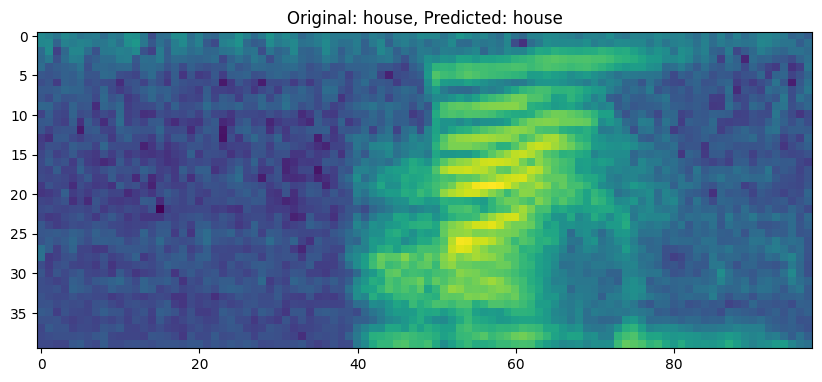

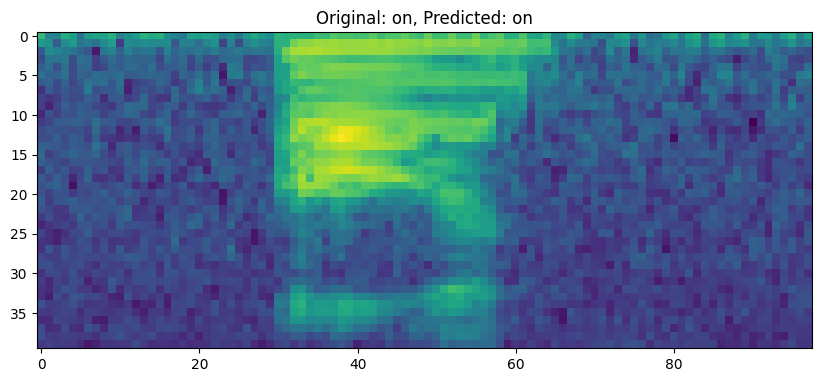

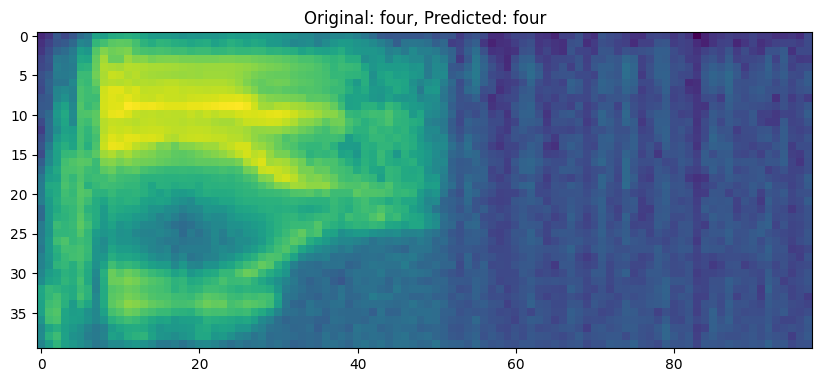

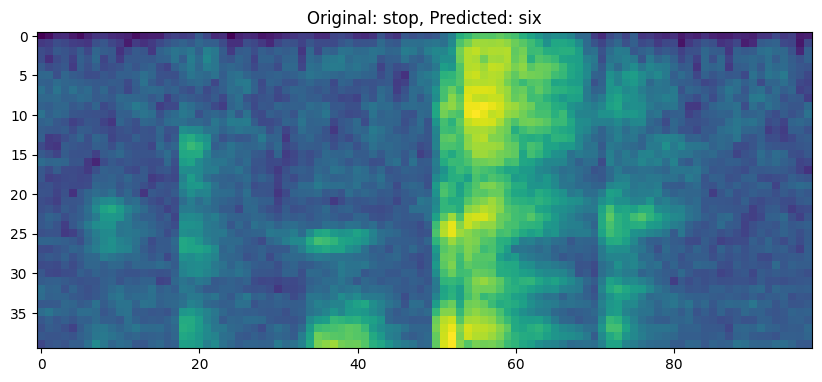

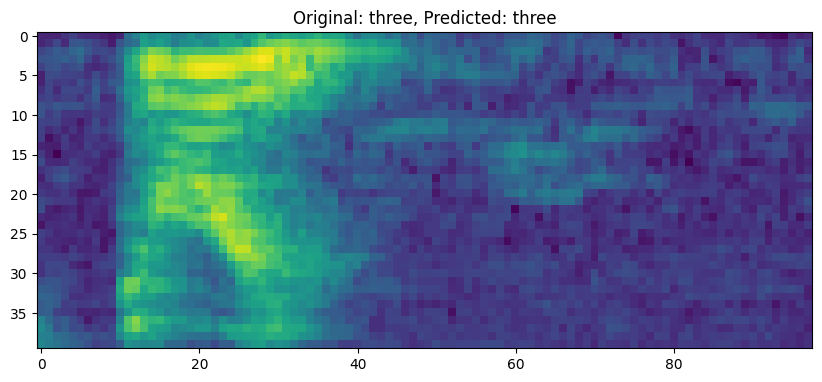

In [92]:
for i in range(N):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(imgs[i])
    ax.set_title(f'Original: {original_label[i]}, Predicted: {predicted_label[i]}')
    plt.show()

Original label: happy
Predicted label: happy
